Virtual cores
====
This figure displays a selection of respresentative "sediment cores" based on the random media models simulated in the paper.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.gridspec as gridspec

import numpy as np
import pickle
from sbp_modelling.multi_source import model
import gstools as gs
from string import ascii_lowercase

plt.style.use('./mpl/manuscript.mplstyle')
cmap = ListedColormap(['#ffe8d6', '#ddbea9',])
plt.rcParams['figure.figsize'] = plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1] * 1.5

Set the $x$ location of the virtual core, the length, diameter and sampling

In [2]:
x_core = 2500
core_length = 3
core_diameter = 0.1
core_d_x = core_d_z = 0.0025

core_x = np.linspace(0, core_diameter, int(core_diameter // core_d_x))
core_z = np.linspace(0, core_length, int(core_length // core_d_z))

In [3]:
params = [(x, 0.05, 1001) for x in (500., 50., 5.0, 0.5, 0.05)]

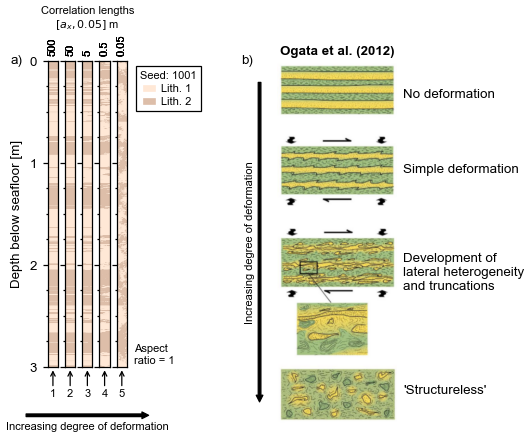

In [4]:
n_cores = len(params)

fig = plt.figure(constrained_layout=False, figsize=(5, 4))
g = gridspec.GridSpec(2, n_cores + 2, figure=fig,
                        hspace=0.25,
                        wspace=0.0,
                        width_ratios=[1] * len(params) + [2, 20],
                        height_ratios=[0.95, 0.05])

ax = []
for i in range(n_cores + 1):
    ax.append(fig.add_subplot(g[0, i]))

for i in range(n_cores):
    a_x, a_z, seed = params[i]
    mtd_corr = gs.Exponential(dim=2, var=2, len_scale=[a_z, a_x]) # Gaussian
    mtd_srf = gs.SRF(mtd_corr, seed=seed)
    mtd_srf.structured([core_z, core_x])
    for j, z in enumerate(np.array_split(core_z, n_cores)):
        gs.transform.binary(mtd_srf, upper=0, lower=1)
        ax[i].pcolormesh(core_x, z, mtd_srf.field[(core_z >= z.min()) & (core_z <= z.max())],
                         cmap=cmap, rasterized=True, shading='gouraud')
        ax[i].set_aspect(1)
        ax[i].annotate(f'{a_x:g}', xy=(0.5, 1), xycoords='axes fraction',
                          xytext=(0, 3), textcoords='offset points', va='bottom', ha='center',
                          rotation=90, fontsize='small')
        ax[i].set_xticks([])
        ax[i].set_xlim(core_x.min(), core_x.max())
        ax[i].set_ylim(core_z.min(), core_z.max())
        ax[i].invert_yaxis()
        
        ax[i].yaxis.set_major_locator(MultipleLocator(1))
        ax[i].yaxis.set_minor_locator(AutoMinorLocator(n=4))
    ax[i].annotate(f'{i + 1:d}', xy=(0.5, 0), xytext=(0, -18),
                   xycoords='axes fraction', textcoords='offset points', ha='center',
                   arrowprops=dict(arrowstyle='->', shrinkA=0), fontsize='small')
            
ax[int(n_cores // 2)].annotate('Correlation lengths\n$[a_x, 0.05]$ m', xy=(0.5, 1), xycoords='axes fraction',
              xytext=(0, 20), textcoords='offset points', ha='center', fontsize='small')
ax[0].set_ylabel('Depth below seafloor [m]')
for a in ax[1:-1]:
    plt.setp(a.get_yticklabels(), visible=False)
ax[n_cores].axis('off')

lithologies = [
    Line2D([0], [0], color=cmap(0.), lw=4),
    Line2D([0], [0], color=cmap(1.), lw=4)
]
ax[n_cores].legend(
    lithologies,
    ['Lith. 1', 'Lith. 2'],
    title=f'Seed: {seed}',
    loc='upper left', bbox_to_anchor=(0, 1), fontsize='small',
    title_fontsize='small')

ax[-1].annotate('Aspect\nratio = 1', xy=(0, 0), xytext=(2, 2),
                xycoords='axes fraction', textcoords='offset points', fontsize='small')

arrow_1 = fig.add_subplot(g[1, :n_cores])
arrow_1.axis('off')

arrow_1.annotate('', xy=(1.25, 0.5), xytext=(-0.25, 0.5), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(arrowstyle='simple', facecolor='black'),)
arrow_1.annotate('Increasing degree of deformation', xy=(0.5, 0.5), xytext=(0, -4),
                xycoords='axes fraction', textcoords='offset points',
               fontsize='small', ha='center', va='top')

cartoon = fig.add_subplot(g[:, n_cores + 1])


with open('../../manuscript/figures/ogata_vertical.png', 'rb') as f:
    a = plt.imread(f, format='png')
cartoon.imshow(a, aspect=1)
cartoon.axis('off')

cartoon.annotate('Ogata et al. (2012)', xy=(0.5, 1), xytext=(0, 4),
                xycoords='axes fraction', textcoords='offset points',
                ha='center', fontweight='bold')

cartoon.annotate('No deformation', xy=(1, 0.9), xytext=(4, 0),
                xycoords='axes fraction', textcoords='offset points')
cartoon.annotate('Simple deformation', xy=(1, 0.7), xytext=(4, -2),
                xycoords='axes fraction', textcoords='offset points')
cartoon.annotate('Development of\nlateral heterogeneity\nand truncations', xy=(1, 0.35), xytext=(4, 4),
                xycoords='axes fraction', textcoords='offset points')
cartoon.annotate("'Structureless'", xy=(1, 0.1), xytext=(4, -4),
                xycoords='axes fraction', textcoords='offset points')

cartoon.annotate('', xy=(-0.15, 0.05), xytext=(-0.15, 0.95), xycoords='axes fraction', textcoords='axes fraction',
            arrowprops=dict(arrowstyle='simple', facecolor='black'),)
cartoon.annotate('Increasing degree of deformation', xy=(-0.15, 0.5), xytext=(-9, 0),
                xycoords='axes fraction', textcoords='offset points', rotation=90,
               fontsize='small', va='center')

def label_axis(axis, i, offset=(-15, 0)):
    axis.annotate(f'{ascii_lowercase[i]})', xy=(0, 1), xytext=offset, textcoords='offset points', xycoords='axes fraction', va='center', ha='right')

counter = 0
for axis in ax[0], cartoon:
    label_axis(axis, counter)
    counter += 1

In [5]:
fig.savefig('../../manuscript/figures/fig07.pdf')